In [2]:
%%capture
import sys
!{sys.executable} -m pip install ucimlrepo
!{sys.executable} -m pip install seaborn

from ucimlrepo import fetch_ucirepo

Inicialização dos dados:

In [3]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 
  
# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
print(breast_cancer_wisconsin_diagnostic.variables) 


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [4]:
print(X.head())
print(X.describe())
print(X.info())




   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

Análise exploratória dos dados, plotando box-plot para cada atributo em relação a variável target, de modo que pegamos os que apresentam maior correlação com a categorização:

Index(['concave_points3', 'perimeter3', 'concave_points1', 'radius3',
       'perimeter1'],
      dtype='object')


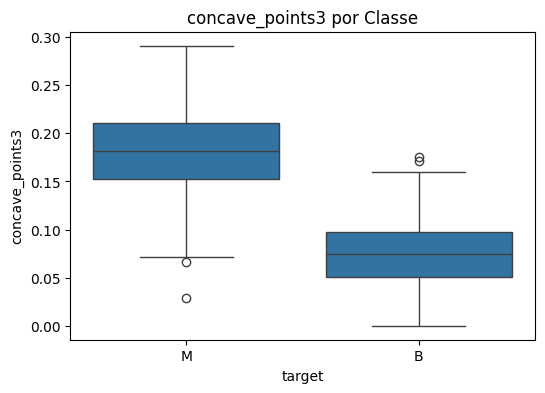

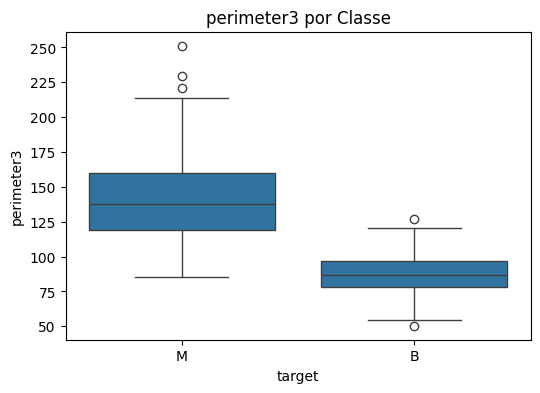

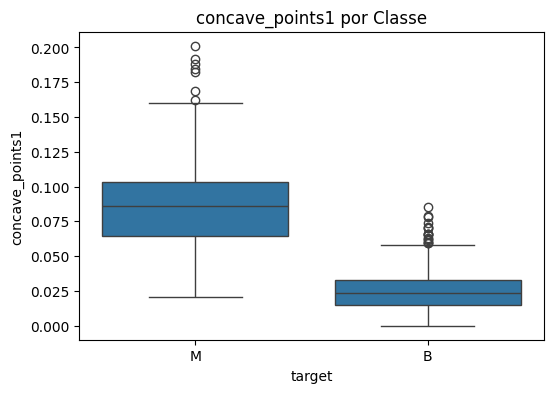

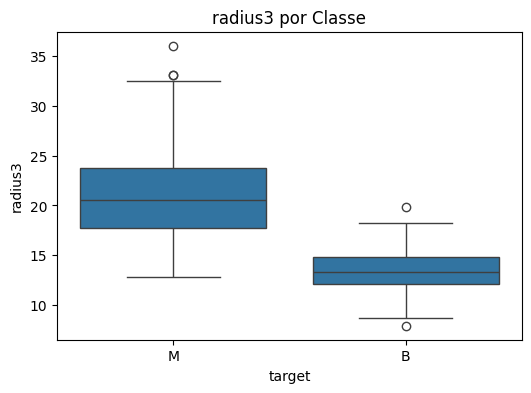

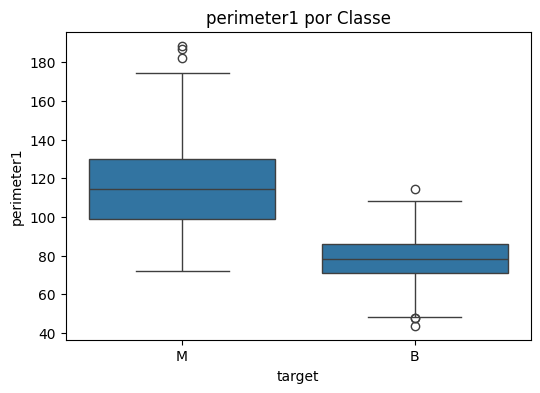

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df = X.copy()
df['target'] = y
df_corr = X.copy()
df_corr['target'] = y  


# Importante mapear para número pois estamos realizando a correlação com a variável target
df_corr['target'] = df_corr['target'].map({'M': 1, 'B': 0})

correlacoes = df_corr.corr(numeric_only=True)['target'].abs().sort_values(ascending=False)
top5 = correlacoes.index[1:6]
print(top5)

for col in top5:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col} por Classe')
    plt.savefig(f'{col}_boxplot.png')
    plt.show()


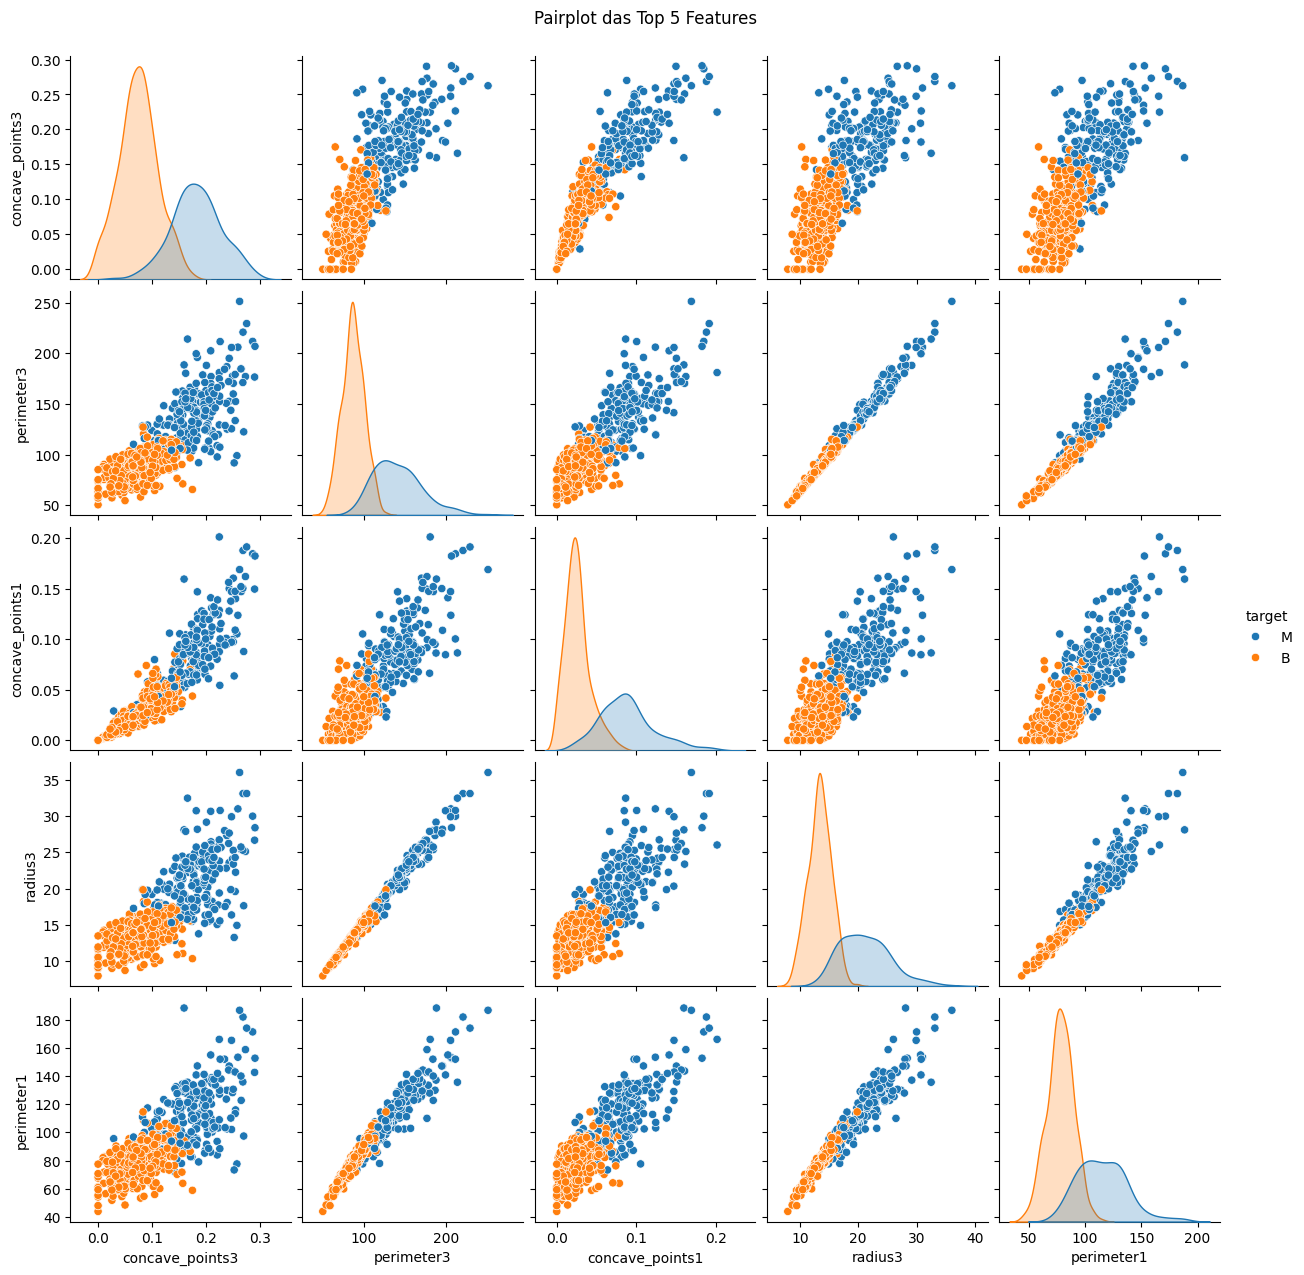

In [6]:
sns.pairplot(df[top5.tolist() + ['target']], hue='target', diag_kind='kde')
plt.suptitle("Pairplot das Top 5 Features", y=1.02)
plt.show()


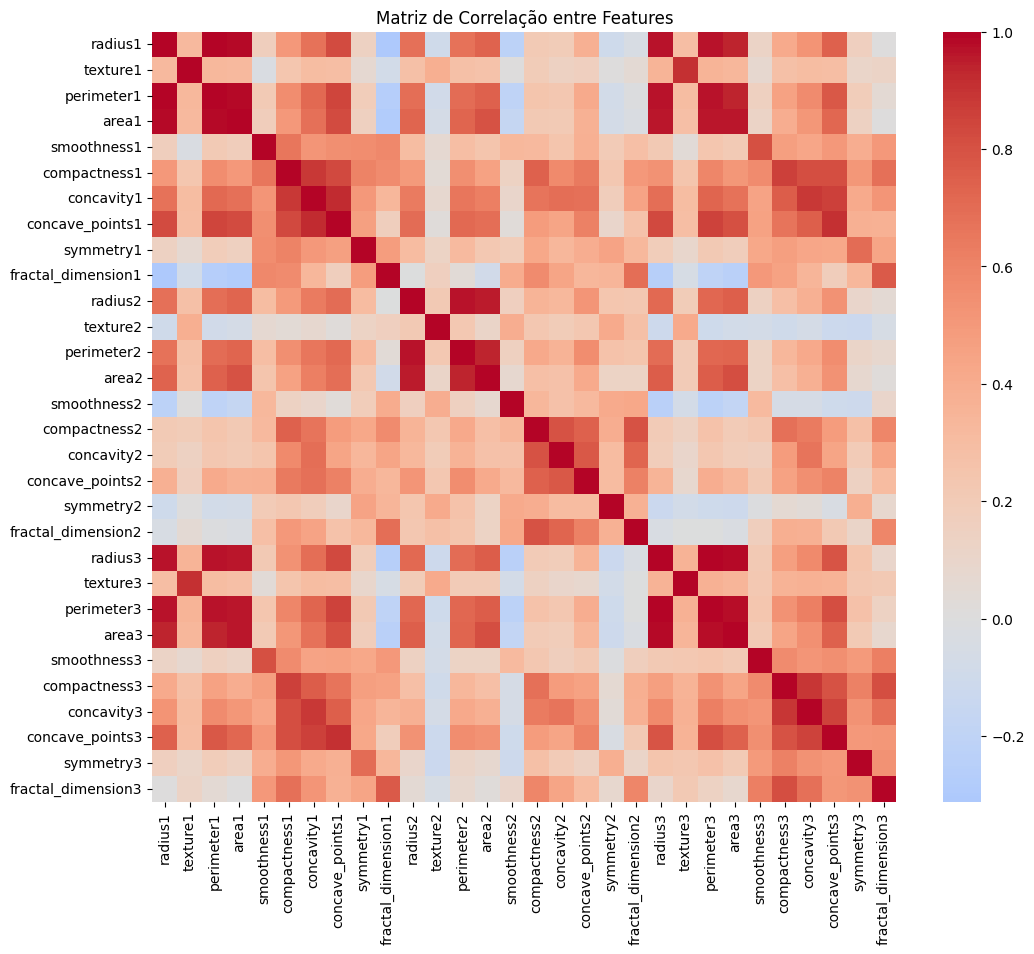

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap='coolwarm', center=0)
plt.title("Matriz de Correlação entre Features")
plt.savefig('correlation_matrix.png')
plt.show()


Realizada a divisão do conjunto de dados entre treino/teste, inicializando o modelo com o fit.
Em seguida também é realizado a predição, verificando se o modelo treinado tem bom desempenho com o conjunto de teste, ainda sem cross validation e otimizações:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=37,
    stratify=y
)

decision_tree = DecisionTreeClassifier(random_state=37)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)


print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))



Acurácia: 0.935672514619883
Relatório de Classificação:
               precision    recall  f1-score   support

           B       0.94      0.95      0.95       107
           M       0.92      0.91      0.91        64

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Matriz de Confusão:
 [[102   5]
 [  6  58]]


Realização do Cross Validation, de modo que colocamos k=10:

In [10]:
scores = cross_val_score(decision_tree, X, y, cv=10)
print("Acurácia média:", scores.mean())
print("Desvio padrão:", scores.std())

Acurácia média: 0.9086779448621554
Desvio padrão: 0.025644579614464626


Otimização dos hiperparâmetros, focamos apenas na altura máxima da árvore e na variação dos critérios de impureza:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [2, 3, 4, 5, None],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=37), params, cv=10)
grid.fit(X_train, y_train)

results_df = pd.DataFrame(grid.cv_results_)

results_filtered = results_df[[
    'param_max_depth', 
    'param_criterion', 
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
]].sort_values(by='mean_test_score', ascending=False)

results_filtered.columns = ['max_depth', 'criterion', 'acuracia_media', 'desvio_padrao', 'ranking']

results_filtered.to_csv("resultados_gridsearch.csv", index=False)
print("Resultados do Grid Search salvos em 'resultados_gridsearch_breast_cancer.csv'")

Resultados do Grid Search salvos em 'resultados_gridsearch_breast_cancer.csv'


Dada a melhor configuração otimizada pela busca em grade, definimos então uma árvore criada com esses parâmetros e então plotamos a mesma:

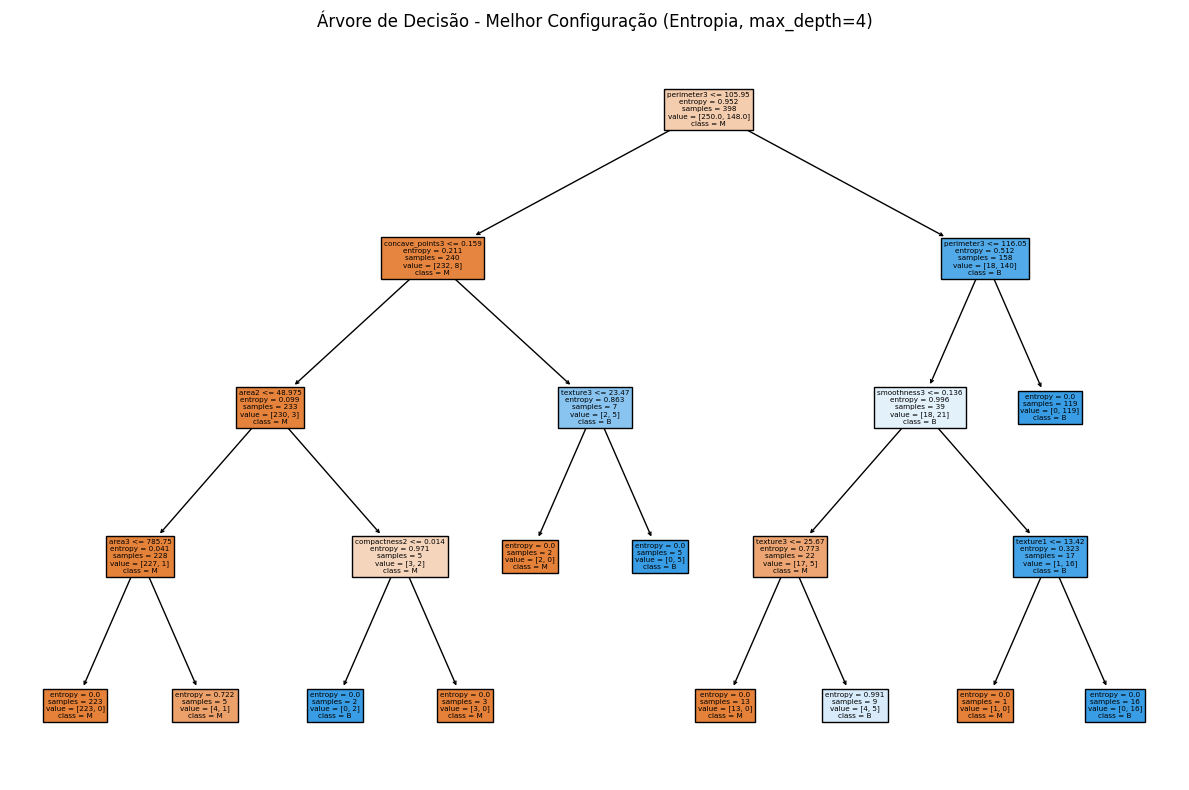

In [12]:
best_clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=37)
best_clf.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(best_clf, feature_names=X.columns, class_names=y.squeeze().unique(), filled=True)
plt.title("Árvore de Decisão - Melhor Configuração (Entropia, max_depth=4)")
plt.tight_layout()
plt.savefig('best_decision_tree_breast_cancer.png')
plt.show()